# Lightning Flash Dataset: EDA with K-Means Clustering

In [53]:
# 1.Import libraries
import duckdb as db
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set() # plot styling
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline
warnings.filterwarnings('ignore')

In [54]:
# 2.Load dataset - db connections
conn = db.connect("glmFlash.db") # Path to db file
lat_df = conn.execute("SELECT * FROM tbl_flash_lat;").df() # latitude co-ordinates
lon_df = conn.execute("SELECT * FROM tbl_flash_lon;").df() # longitude co-ordinates
print(lat_df.describe(), "\n")
print(lon_df.describe())

                lat
count  19830.000000
mean       3.707215
std       23.465398
min      -50.636160
25%      -16.387270
50%        6.568098
75%       20.767033
max       53.227520 

                lon
count  19830.000000
mean     -59.517493
std      132.708378
min     -179.993500
25%     -153.827320
50%     -104.076540
75%      -82.323105
max      179.960190


In [55]:
# 3.Preprocess the data - Cleaning up the data
# assuming each flash point corresponds to a lightning discharge?
lat_df.drop(lat_df.columns[[2]],axis=1,inplace=True)  # drop file name
lon_df.drop(lon_df.columns[[2]],axis=1,inplace=True)  # drop file name
print(lat_df.info(), "\n")
print(lon_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19830 entries, 0 to 19829
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ts_date  19830 non-null  datetime64[ns]
 1   lat      19830 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 310.0 KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19830 entries, 0 to 19829
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ts_date  19830 non-null  datetime64[ns]
 1   lon      19830 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 310.0 KB
None


In [56]:
# remove duplicates
lat_df.drop_duplicates(subset=['ts_date'], inplace=True)
lon_df.drop_duplicates(subset=['ts_date'], inplace=True)
print(lat_df.ts_date.value_counts(), "\n")
print(lon_df.ts_date.value_counts())
# join dataframes
geo_df = lon_df.join(lat_df.set_index('ts_date'), on='ts_date')
geo_df.size
# dataset time window
print(f"Start: {geo_df.ts_date.min()}; End: {geo_df.ts_date.max()}")

2023-01-01 00:12:22.634853    1
2023-01-02 00:48:15.706877    1
2023-01-02 00:48:13.698790    1
2023-01-02 00:48:08.049136    1
2023-01-02 00:48:05.912872    1
                             ..
2023-01-01 01:45:22.251088    1
2023-01-01 01:45:22.246892    1
2023-01-01 01:08:17.658888    1
2023-01-01 01:08:16.630430    1
2023-01-02 01:39:37.574200    1
Name: ts_date, Length: 7322, dtype: int64 

2023-01-01 00:16:24.616618    1
2023-01-02 00:58:45.834670    1
2023-01-02 00:58:44.168385    1
2023-01-02 00:58:43.397804    1
2023-01-02 00:58:39.964905    1
                             ..
2023-01-01 01:20:39.573511    1
2023-01-01 01:29:37.811478    1
2023-01-01 01:29:35.925081    1
2023-01-01 01:29:35.859087    1
2023-01-02 01:39:37.574200    1
Name: ts_date, Length: 7322, dtype: int64
Start: 2023-01-01 00:00:00.180820; End: 2023-01-02 01:59:58.577482


Text(0.5, 1.0, 'Raw Flash Events')

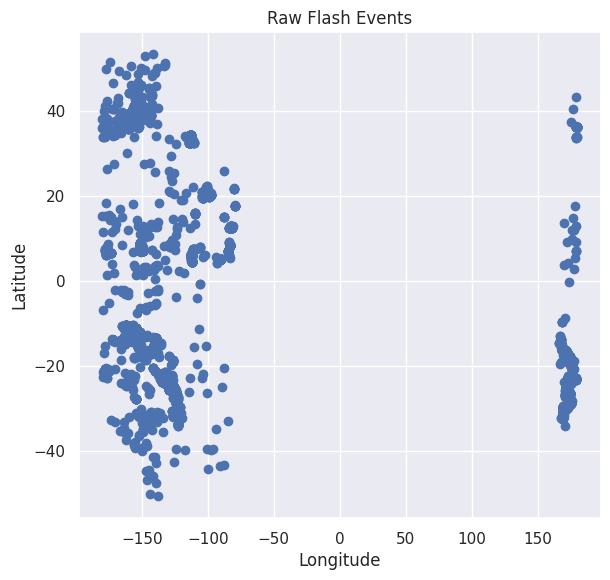

In [57]:
# 3.Raw visualization
plt.figure(figsize=(6, 6))
plt.scatter(x=geo_df['lon'], y=geo_df['lat'])
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.title("Raw Flash Events")

In [58]:
# 4. Implement K-Means clustering algorithm
k = 2
X = geo_df.loc[:, ["lon", "lat"]]
kmeans = KMeans(n_clusters=k)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")
X.head()

,lon,lat,Cluster
0,-103.650860,20.465542,0
1,-175.559800,7.099273,0
2,-98.207855,20.167400,0
3,-100.783440,20.752630,0
4,-104.129340,20.865643,0


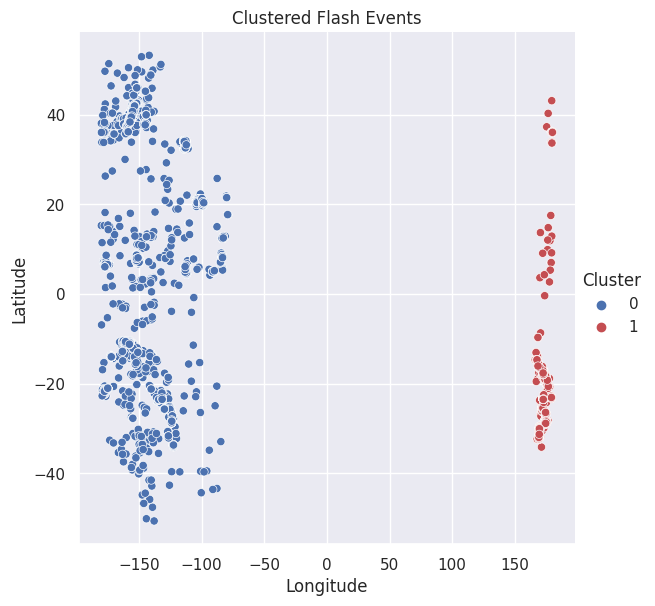

In [59]:
# Plot clusters
g = sns.relplot(
    x="lon", y="lat", hue="Cluster", data=X, height=6,  palette=["b", "r"], sizes=(10, 100)
).set(title='Clustered Flash Events', xlabel="Longitude", ylabel="Latitude")

In [60]:
# 5a. Evaluate results, silhouette score
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice we start at 2 clusters for silhouette coefficient
for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)

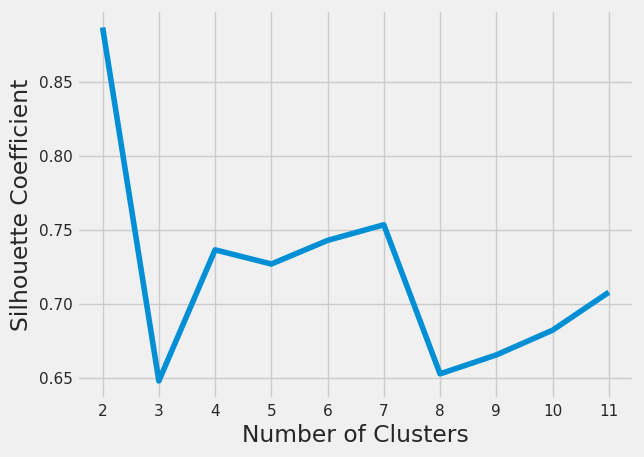

In [61]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 12), silhouette_coefficients)
plt.xticks(range(2, 12))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [62]:
# 5b. Evaluate results, elbow method
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 500,
    "random_state": 45,
}

# A list holds the sum of the squared error for each k
sse = []

# Return SSE for each k
for k in range(1, 12):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

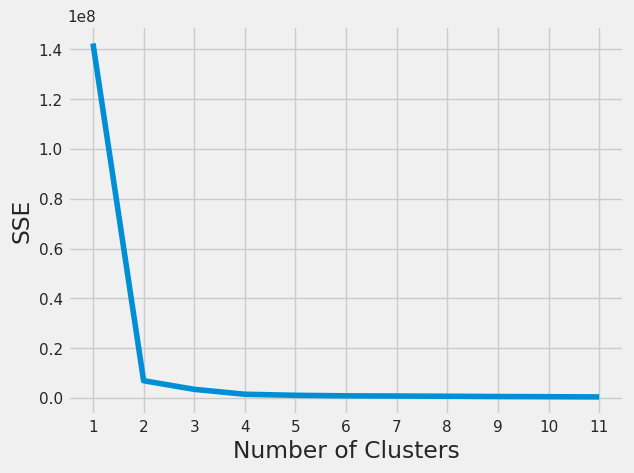

In [63]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 12), sse)
plt.xticks(range(1, 12))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()